#Librerías, Funciones Auxiliares y Descarga del dataset




In [3]:
# Importación de bibliotecas necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import io

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from shapely import wkt
from shapely.geometry import Point

np.random.seed(42)



In [4]:
# Funciones Auxiliares

# Calculo de la distáncia geodésica: Devuelve la distancia en km entre dos puntos (lat, lon)

def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0088 * c  # Radio de la Tierra en Km


In [5]:
# Calcula y devuelve métricas de evaluación de un modelo.
# recibe: Valores reales y Predicciones
# entrerga: cuatro métricas de evaluación.
def eval_metrics(y, yhat):
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, yhat)
    r2 = r2_score(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    return {"R2": r2, "RMSE": rmse, "MAE": mae, "MAPE%": mape}

# ---------------------------------------------
#         Funciones de Graficación para GD
# Reciben:
# Devuelven:
# ---------------------------------------------

# Grafica la historia de la pérdida para cada modelo de Gradiente Descendente.
def plot_loss_history(models):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        if hasattr(model, 'loss_curve_') and model.loss_curve_:
            plt.plot(model.loss_curve_, label=f'{name}')

    plt.title('Pérdida (MSE) vs. Épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Grafica los residuos para cada modelo de GD en el conjunto de prueba.
def plot_residuals(models, X_test, y_test):
    fig, axes = plt.subplots(1, len(models), figsize=(18, 6), sharey=True)
    fig.suptitle('Análisis de Residuos en el Conjunto de Prueba', fontsize=16)

    # Asegura que axes sea un array incluso con un solo modelo
    if len(models) == 1:
        axes = [axes]

    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred

        ax = axes[i]
        sns.scatterplot(x=y_pred, y=residuals, ax=ax, alpha=0.5, s=20)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_title(f'Modelo: {name}')
        ax.set_xlabel('Valores Predichos')
        ax.set_ylabel('Residuos')
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------------------------------------------------------
# Clase Gradiente descendente custom (solo una vez)
# ---------------------------------------------------------
class GDLinear:
    """Implementación de un modelo de regresión lineal con Gradiente Descendente."""
    def __init__(self, lr=0.01, epochs=200, mode="batch", batch_size=64, shuffle=True, verbose=False):
        self.lr = lr
        self.epochs = epochs
        self.mode = mode
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.verbose = verbose
        self.coef_ = None
        self.intercept_ = None
        self.loss_curve_ = []

    def fit(self, X, y):
        Xb = np.c_[np.ones((X.shape[0], 1)), X]
        n, d = Xb.shape
        rng = np.random.default_rng(42)
        w = rng.normal(0, 0.01, size=(d, ))

        # Corrección importante: el cálculo de la pérdida para minibatch y stochastic
        # debe ser consistente. Se calcula el MSE promedio al final de cada época.
        for epoch in range(self.epochs):
            loss_epoch = 0.0
            if self.mode == "batch":
                yhat = Xb @ w
                grad = (2/n) * Xb.T @ (yhat - y)
                w -= self.lr * grad
                loss = ((y - yhat)**2).mean()
                self.loss_curve_.append(loss)
            elif self.mode == "stochastic":
                idxs = np.arange(n)
                if self.shuffle:
                    rng.shuffle(idxs)

                for i in idxs:
                    xi = Xb[i:i+1, :]
                    yi = y[i]
                    yhat = xi @ w
                    grad = 2 * xi.T @ (yhat - yi)
                    w -= self.lr * grad.flatten()

                # Calculamos la pérdida promedio al final de la época
                loss = mean_squared_error(y, Xb @ w)
                self.loss_curve_.append(loss)
            else:  # minibatch
                idxs = np.arange(n)
                if self.shuffle:
                    rng.shuffle(idxs)

                for start in range(0, n, self.batch_size):
                    end = min(start + self.batch_size, n)
                    xb = Xb[idxs[start:end], :]
                    yb = y[idxs[start:end]]
                    yhat = xb @ w
                    grad = (2/xb.shape[0]) * xb.T @ (yhat - yb)
                    w -= self.lr * grad

                # Calculamos la pérdida promedio al final de la época
                loss = mean_squared_error(y, Xb @ w)
                self.loss_curve_.append(loss)

        self.intercept_ = w[0]
        self.coef_ = w[1:]
        return self

    def predict(self, X):
        return self.intercept_ + X @ self.coef_


In [6]:
# SE CARGA DE ESTA FORMA PARA HACER MAS RAPIDO. LA VERSION FINAL TENDRA EL CODIGO SIGUIENTE
df = pd.read_csv('uber_fares.csv')

#Preprocesamiento de los Datos

In [7]:
# Se comprueba por observación que las columnas date y pickup_datetime tienen la misma información pero en
# diferente formato. Para validar esto, se calcula el porcentaje de coincidencias.

# 1) Convertir a datetime
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce")
df["pickup_parsed"] = pd.to_datetime(df["pickup_datetime"], errors="coerce")

# 2) Normalizar: quitar microsegundos y eliminar zona horaria
df["date_norm"] = df["date_parsed"].dt.floor("s")
df["pickup_norm"] = df["pickup_parsed"].dt.tz_convert(None)

# 3) Comparar
comparisons = df["date_norm"] == df["pickup_norm"]
count_equal = comparisons.sum()
total = len(df)

print(f"Coincidencias: {count_equal} / {total} ({count_equal/total:.2%})")

Coincidencias: 200000 / 200000 (100.00%)


In [8]:
# -----------------------------------------------------
#   Limpieza de los datos de fecha y hora del dataset
# -----------------------------------------------------
# Renombrar pickup_parsed a date_clean
df.rename(columns={'pickup_parsed': 'date_clean'}, inplace=True)
# Verificada la coincidencia se elimina las columnas innecesarias
df.drop(['date', 'date_norm', 'date_parsed', 'pickup_norm', 'pickup_datetime'], axis=1, inplace=True)

In [9]:
# Comprobacion de lo hecho hasta ahora
df.describe()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [10]:
# TODAS LAS COLUMNAS tienen LOS TIPOS DE DATOS CORRECTOS
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   fare_amount        200000 non-null  float64            
 2   pickup_longitude   200000 non-null  float64            
 3   pickup_latitude    200000 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    200000 non-null  int64              
 7   date_clean         200000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 12.2 MB


In [11]:
# Todos los valores de fecha y hora ya quedaron limpios en el df con lo cual YA AGREGAMOS ATRIBUTOS Y CODIFICACION SENO_COSENO
# Para date_clean usamos codificación cíclica

# -------------------- Nuevas variables explicativas -------------------
# Año, mes día, hora, día de la semana, semana del mes, ¿es fin de semana?
df['year'] = df['date_clean'].dt.year
df['month'] = df['date_clean'].dt.month
df['day'] = df['date_clean'].dt.day
df['hour'] = df['date_clean'].dt.hour
df['weekday'] = df['date_clean'].dt.weekday
df['week_of_month'] = ((df['day'] - 1) // 7) + 1
df['tipo_dia'] = df['weekday'].apply(lambda x: 'semana' if x <= 3 else 'fin_de_semana')

# -------------------Transformación cíclica para la hora ------------
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
df['is_off_peak_hour'] = df['hour'].isin(list(range(10, 17)) + list(range(1, 6))).astype(int)


In [12]:
df.head(3)

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,date_clean,year,month,day,hour,weekday,week_of_month,tipo_dia,hour_sin,hour_cos,is_off_peak_hour
0,24238194,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015-05-07 19:52:06+00:00,2015,5,7,19,3,1,semana,-0.965926,0.258819,0
1,27835199,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009-07-17 20:04:56+00:00,2009,7,17,20,4,3,fin_de_semana,-0.866025,0.500000,0
2,44984355,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009-08-24 21:45:00+00:00,2009,8,24,21,0,4,semana,-0.707107,0.707107,0


In [13]:
# ---- Nuevas variables explicativas -------
# Cálculo de la distancia de cada viaje

df['distance_km'] = haversine(df['pickup_latitude'].values, df['pickup_longitude'].values,
                                        df['dropoff_latitude'].values, df['dropoff_longitude'].values)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                200000 non-null  int64              
 1   fare_amount        200000 non-null  float64            
 2   pickup_longitude   200000 non-null  float64            
 3   pickup_latitude    200000 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    200000 non-null  int64              
 7   date_clean         200000 non-null  datetime64[ns, UTC]
 8   year               200000 non-null  int32              
 9   month              200000 non-null  int32              
 10  day                200000 non-null  int32              
 11  hour               200000 non-null  int32              
 12  weekday            200000 non-

In [15]:
df.columns

Index(['key', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'date_clean', 'year', 'month', 'day', 'hour', 'weekday',
       'week_of_month', 'tipo_dia', 'hour_sin', 'hour_cos', 'is_off_peak_hour',
       'distance_km'],
      dtype='object')

In [16]:
df[df['fare_amount'] <= 0].count()

key                  22
fare_amount          22
pickup_longitude     22
pickup_latitude      22
dropoff_longitude    22
dropoff_latitude     22
passenger_count      22
date_clean           22
year                 22
month                22
day                  22
hour                 22
weekday              22
week_of_month        22
tipo_dia             22
hour_sin             22
hour_cos             22
is_off_peak_hour     22
distance_km          22
dtype: int64

En nuestro análisis, identificamos 22 registros en los que la tarifa (fare_amount) presenta valores negativos. Dado que estas tarifas no son lógicas ni coherentes con la naturaleza del dataset, decidimos eliminar estas filas. Consideramos que estos valores son errores o anomalías en los datos, ya que no representan situaciones reales de viajes en Uber.

Cabe destacar que, en todo momento, nuestro enfoque ha sido modificar lo menos posible la variable fare_amount, ya que esta es nuestra variable objetivo para la predicción. La integridad de esta variable es crucial para el éxito del modelo, por lo que nos hemos asegurado de realizar solo los ajustes estrictamente necesarios para mejorar la calidad de los datos sin alterar su distribución ni introducir sesgos.

In [17]:
df=df[df['fare_amount'] > 0]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199978 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                199978 non-null  int64              
 1   fare_amount        199978 non-null  float64            
 2   pickup_longitude   199978 non-null  float64            
 3   pickup_latitude    199978 non-null  float64            
 4   dropoff_longitude  199977 non-null  float64            
 5   dropoff_latitude   199977 non-null  float64            
 6   passenger_count    199978 non-null  int64              
 7   date_clean         199978 non-null  datetime64[ns, UTC]
 8   year               199978 non-null  int32              
 9   month              199978 non-null  int32              
 10  day                199978 non-null  int32              
 11  hour               199978 non-null  int32              
 12  weekday            199978 non-null 

#Split train/test

In [19]:
# -----------------------------
# 7) Preparación de features y split train/test
# -----------------------------
print("\n== 7) PREPARACIÓN PARA MODELADO ==")
features = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'date_clean', 'year', 'month', 'day', 'hour', 'weekday',
       'week_of_month', 'tipo_dia', 'hour_sin', 'hour_cos', 'is_off_peak_hour',
       'distance_km','fare_amount']
data_frame = df[features].copy()

# División train/test (validación simple) con random_state fijo para reproducibilidad
X_train, X_test = train_test_split(data_frame, test_size=0.2, random_state=42)

print("Train/Test shapes:", X_train.shape, X_test.shape)


== 7) PREPARACIÓN PARA MODELADO ==
Train/Test shapes: (159982, 18) (39996, 18)


#Imputación de valores, Ingeniería de variables, Detección y Tratamiento de Outliers

Para asegurar la calidad y relevancia de los datos utilizados en nuestro análisis, hemos seleccionado únicamente aquellos registros del dataset de Uber fares de Nueva York cuyas coordenadas de latitud y longitud se encuentran dentro de los límites geográficos de la ciudad. Esta selección tiene como objetivo eliminar cualquier dato que pueda corresponder a viajes fuera de la zona metropolitana de Nueva York, garantizando que el modelo esté entrenado con información pertinente y representativa de los patrones de movilidad dentro de la ciudad.

Es importante señalar que este filtrado implica una pérdida aproximada del 2% para cada dataset, ya que algunos registros corresponden a viajes que ocurren fuera de los límites urbanos de Nueva York. Sin embargo, consideramos que esta pequeña pérdida es aceptable, dado que asegura que los resultados sean más precisos y reflejen la realidad de los viajes dentro de la ciudad, sin la distorsión de datos atípicos provenientes de áreas no relacionadas con el objetivo del análisis.

In [20]:
# Definir los rangos de latitud y longitud
lat_min, lat_max = 40.0, 41.0
lon_min, lon_max = -75.0, -73.0
pre_pros_train=len(X_train)
pre_pros_test=len(X_test)

# Filtrar X_train para quedarse solo con las filas que cumplen la condición de estar en NYC
X_train = X_train[
    (X_train['pickup_latitude'] >= lat_min) & (X_train['pickup_latitude'] <= lat_max) &
    (X_train['pickup_longitude'] >= lon_min) & (X_train['pickup_longitude'] <= lon_max)
]
post_pros_train=len(X_train)
print("Filas dentro del rango de NYC en X_train:")
print(f"Número de filas originales: {pre_pros_train}")
print(f"Número de filas filtradas: {post_pros_train}")

# Filtrar X_test para quedarse solo con las filas que cumplen la condición de estar en NYC
X_test = X_test[
    (X_test['pickup_latitude'] >= lat_min) & (X_test['pickup_latitude'] <= lat_max) &
    (X_test['pickup_longitude'] >= lon_min) & (X_test['pickup_longitude'] <= lon_max)
]

post_pros_test=len(X_test)
print("\nFilas dentro del rango de NYC en X_test:")
print(f"Número de filas originales: {pre_pros_test}")
print(f"Número de filas filtradas: {post_pros_test}")

Filas dentro del rango de NYC en X_train:
Número de filas originales: 159982
Número de filas filtradas: 156710

Filas dentro del rango de NYC en X_test:
Número de filas originales: 39996
Número de filas filtradas: 39200


In [21]:
# Características para el proceso de limpieza e imputación
features_isolation_forest = ['pickup_latitude', 'pickup_longitude',
                             'dropoff_latitude', 'dropoff_longitude',
                              'distance_km', 'fare_amount']

Considerando que el número máximo de pasajeros que puede transportar un vehículo convencional de Uber es limitado, decidimos tratar aquellos registros en los que el número de pasajeros supera este rango. Específicamente, para los valores fuera de un rango razonable de 1 a 6 pasajeros, se asignaron como nulos dichos registros. Posteriormente, para evitar distorsiones por valores extremos o outliers, estos valores nulos fueron imputados utilizando la mediana, ya que este enfoque es menos sensible a posibles valores atípicos y asegura una imputación robusta.

Además, transformamos esta variable en variables dummies para representar las categorías de tipo de Uber. Específicamente, consideramos dos categorías:

Uber Normal (hasta 4 pasajeros)

Uber XL (hasta 6 pasajeros).

Esta transformación permite que el modelo capture las diferencias entre los distintos tipos de vehículos y facilite la predicción de tarifas según el tipo de Uber.

In [22]:
"""
Teniendo en cuenta que la cantidad máxima de pasajeros que entran en un auto convencional de
Uber, se toman como nulos aquellos valores por fuera de este rango y luego se imputan con un
valor poco sensible a outliers; la mediana.
"""
X_train.loc[(X_train['passenger_count'] < 1) | (X_train['passenger_count'] > 6), 'passenger_count'] = np.nan
median_passenger_train= X_train['passenger_count'].median()
X_train.fillna({'passenger_count': median_passenger_train}, inplace=True)

X_test.loc[(X_test['passenger_count'] < 1) | (X_test['passenger_count'] > 6), 'passenger_count'] = np.nan
X_test.fillna({'passenger_count': median_passenger_train}, inplace=True)

In [23]:
# Definir categorías
X_train['passenger_group'] = np.where(
    X_train['passenger_count'].between(1, 4), '1a4', '5a6'
)

X_test['passenger_group'] = np.where(
    X_test['passenger_count'].between(1, 4), '1a4', '5a6'
)

# Crear dummies
X_train = pd.get_dummies(X_train, columns=['passenger_group'], prefix='passenger', drop_first=True)
X_test = pd.get_dummies(X_test, columns=['passenger_group'], prefix='passenger', drop_first=True)

In [24]:
X_train['passenger_5a6']=X_train['passenger_5a6'].astype(int)
X_test['passenger_5a6']=X_test['passenger_5a6'].astype(int)

In [25]:
# =============================================================================
# ETAPA 2: DETECCIÓN DE OUTLIERS ESTADÍSTICOS
# =============================================================================
print("\n=== ETAPA 2: DETECCIÓN DE OUTLIERS ESTADÍSTICOS ===")

def detect_statistical_outliers(df, features, method='iqr'):
    """
    Detecta outliers usando método IQR o Isolation Forest
    """
    df_no_outliers = df.copy()

    if method == 'iqr':
        # Método IQR (Rango Intercuartílico)
        for feature in features:
            if df_no_outliers[feature].notna().sum() > 0:  # Solo si hay datos no nulos
                Q1 = df_no_outliers[feature].quantile(0.25)
                Q3 = df_no_outliers[feature].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 3 * IQR  # Usar 3*IQR para ser menos agresivo
                upper_bound = Q3 + 3 * IQR

                # Marcar outliers como NaN para posterior imputación
                outlier_mask = (
                    (df_no_outliers[feature] < lower_bound) |
                    (df_no_outliers[feature] > upper_bound)
                )

                # Convertir outliers a NaN en lugar de eliminar filas
                df_no_outliers.loc[outlier_mask, feature] = np.nan

    elif method == 'isolation_forest':
        # Método Isolation Forest (solo para datos completos)
        complete_data = df_no_outliers[features].dropna()
        if len(complete_data) > 100:  # Necesitamos suficientes datos
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            outlier_labels = iso_forest.fit_predict(complete_data)

            # Marcar outliers detectados como NaN
            outlier_indices = complete_data.index[outlier_labels == -1]
            for feature in features:
                df_no_outliers.loc[outlier_indices, feature] = np.nan


    return df_no_outliers



=== ETAPA 2: DETECCIÓN DE OUTLIERS ESTADÍSTICOS ===


In [26]:
print("Detectando outliers en conjunto de entrenamiento...")
X_train_no_outliers = detect_statistical_outliers(X_train, features_isolation_forest, method='isolation_forest')

print("Detectando outliers en conjunto de prueba...")
X_test_no_outliers = detect_statistical_outliers(X_test, features_isolation_forest, method='isolation_forest')



Detectando outliers en conjunto de entrenamiento...
Detectando outliers en conjunto de prueba...


Para incorporar las variables de latitud y longitud en nuestro modelo, recurrimos a un dataset adicional que contiene información sobre los barrios de la ciudad, representados mediante la variable "geometry". Utilizando esta información geoespacial, asignamos una región específica a cada registro de acuerdo con la ubicación del punto de recogida del viaje. Esta asignación se realiza mapeando las coordenadas de cada viaje a una de las regiones predefinidas en el dataset, lo que permite que las variables de latitud y longitud sean transformadas en una variable categórica que representa la región del barrio. De esta forma, conseguimos incorporar la información geográfica de manera que enriquezca el modelo sin perder el contexto urbano en el que ocurren los viajes.

In [28]:
boroughs = pd.read_csv('Borough_Boundaries_20250906.csv')
boroughs["geometry"] = boroughs["the_geom"].apply(wkt.loads)
boroughs = pd.DataFrame(columns=["the_geom", "BoroName"])

In [29]:
# Función para determinar el Barrios según
# https://data.cityofnewyork.us/City-Government/Borough-Boundaries/gthc-hcne/about_data

def asignar_region(lat, lon, boroughs):
    point = Point(lon, lat)
    for _, row in boroughs.iterrows():
        if row["geometry"].contains(point):
            return row["BoroName"]
    return "Otra"

In [30]:
# Nuevo atributo region con el Barrio de inicio del viaje
X_train_no_outliers["region"] = X_train.apply(
    lambda row: asignar_region(row["pickup_latitude"], row["pickup_longitude"], boroughs), axis=1
)
X_test_no_outliers["region"] = X_test.apply(
    lambda row: asignar_region(row["pickup_latitude"], row["pickup_longitude"], boroughs), axis=1
)


Para el procesamiento de nuestros datos, optamos por utilizar un escalado Min-Max. Esta decisión se tomó considerando que variables como distancia o nuestra variable target, que representan magnitudes no negativas, no tienen sentido si se transforman en valores negativos. El escalado Min-Max es adecuado en este caso porque mantiene los valores dentro de un rango específico (en este caso entre 0 y 1), lo que asegura que las variables con valores estrictamente positivos sigan siendo interpretables y coherentes con su naturaleza. Al emplear este tipo de escalado, garantizamos que todas las variables estén en una escala comparable sin alterar su estructura original.

In [31]:
# =============================================================================
# ETAPA 3: ESCALADO MINMAX POST-LIMPIEZA
# =============================================================================
print("\n=== ETAPA 3: ESCALADO MINMAX ===")

# Función para escalar preservando NaN
def safe_scale_features(df, features, scaler):
    """Escala características preservando valores NaN"""
    df_scaled = df.copy()
    # Identify rows where at least one feature to be scaled is not NaN
    mask_notna_any = df[features].notna().any(axis=1)

    if mask_notna_any.sum() > 0:  # Only scale if there are rows with data
        # Select the subset of data to scale (only specified features and non-NaN rows)
        data_to_scale = df.loc[mask_notna_any, features]

        # Apply the scaler
        scaled_data = scaler.transform(data_to_scale)

        # Assign the scaled data back to the original DataFrame, preserving NaN positions
        # This is done by creating a temporary DataFrame for the scaled data
        # and then using update or direct assignment based on the index
        df_scaled.loc[mask_notna_any, features] = scaled_data

    return df_scaled


=== ETAPA 3: ESCALADO MINMAX ===


In [32]:

# =============================================================================
# ETAPA 3.1: ESCALADO MINMAX POST-LIMPIEZA (Alternativo a RobustScaler)
# =============================================================================
print("\n=== ETAPA 3.1: ESCALADO MINMAX ===")

from sklearn.preprocessing import MinMaxScaler

# Inicializar el escalador MinMax
minmax_scaler = MinMaxScaler()

# Ajustar el escalador SOLO con datos limpios de entrenamiento (sin NaN)
# Usamos las mismas features definidas para Isolation Forest
train_clean_for_minmax_scaling = X_train_no_outliers[features_isolation_forest].dropna()
print(f"Datos usados para ajustar escalador MinMax: {len(train_clean_for_minmax_scaling)} registros")

minmax_scaler.fit(train_clean_for_minmax_scaling)

# Crear copias para escalado MinMax
X_train_scaled = X_train_no_outliers.copy()
X_test_scaled = X_test_no_outliers.copy()

# Aplicar escalado MinMax preservando NaN
print("Aplicando escalado MinMax a datos de entrenamiento...")
X_train_scaled = safe_scale_features(X_train_scaled, features_isolation_forest, minmax_scaler)

print("Aplicando escalado MinMax a datos de prueba...")
X_test_scaled = safe_scale_features(X_test_scaled, features_isolation_forest, minmax_scaler)



=== ETAPA 3.1: ESCALADO MINMAX ===
Datos usados para ajustar escalador MinMax: 141038 registros
Aplicando escalado MinMax a datos de entrenamiento...
Aplicando escalado MinMax a datos de prueba...


In [ ]:
# =============================================================================
# ETAPA 4: IMPUTACIÓN KNN CON VALIDACIÓN
# ATENCION: TARDA ALREDEDOR DE 4 MINUTOS
# =============================================================================
print("\n=== ETAPA 4: IMPUTACIÓN KNN ===")

# Configurar imputador KNN
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Ajustar con datos escalados de entrenamiento
print("Ajustando imputador KNN...")
knn_imputer.fit(X_train_scaled[features_isolation_forest])

# Crear copias para imputación
X_train_imputed = X_train_scaled.copy()
X_test_imputed = X_test_scaled.copy()

# Aplicar imputación
print("Aplicando imputación a conjunto de entrenamiento...")
X_train_imputed[features_isolation_forest] = knn_imputer.transform(
    X_train_scaled[features_isolation_forest]
)

print("Aplicando imputación a conjunto de prueba...")
X_test_imputed[features_isolation_forest] = knn_imputer.transform(
    X_test_scaled[features_isolation_forest]
)




=== ETAPA 4: IMPUTACIÓN KNN ===
Ajustando imputador KNN...
Aplicando imputación a conjunto de entrenamiento...


In [32]:
X_train_imputed = pd.get_dummies(X_train_imputed, columns=['tipo_dia', 'region', 'week_of_month'], drop_first=True)
dummy_cols = [col for col in X_train_imputed.columns if col.startswith('tipo_dia_')
             or col.startswith('region_')
             or col.startswith('week_of_month_')]
X_train_imputed[dummy_cols] = X_train_imputed[dummy_cols].astype(int)


X_test_imputed = pd.get_dummies(X_test_imputed, columns=['tipo_dia', 'region', 'week_of_month'], drop_first=True)
dummy_cols = [col for col in X_test_imputed.columns if col.startswith('tipo_dia_')
             or col.startswith('region_')
             or col.startswith('week_of_month_')]
X_test_imputed[dummy_cols] = X_test_imputed[dummy_cols].astype(int)

In [33]:
X_train_imputed.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'date_clean', 'year', 'month',
       'day', 'hour', 'weekday', 'hour_sin', 'hour_cos', 'is_off_peak_hour',
       'distance_km', 'fare_amount', 'passenger_5a6', 'tipo_dia_semana',
       'region_Brooklyn', 'region_Manhattan', 'region_Otra', 'region_Queens',
       'region_Staten Island', 'week_of_month_2', 'week_of_month_3',
       'week_of_month_4', 'week_of_month_5'],
      dtype='object')

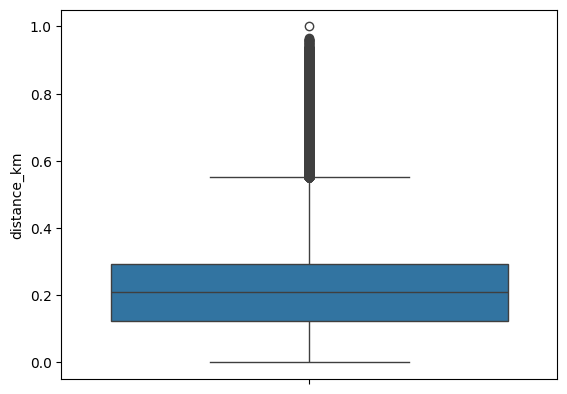

In [34]:
sns.boxplot(X_train_imputed['distance_km'])
plt.show()

La variable distancia sigue una distribución sesgada a la derecha, lo que indica que la mayoría de los viajes tienen distancias relativamente cortas, mientras que los viajes de mayor distancia son menos frecuentes. Debido a que esta variable ha sido escalada previamente en el rango de 0 a 1, la distribución de las distancias está contenida dentro de ese intervalo. Esto implica que, aunque la mayoría de los valores se concentran cerca de 0, aún existen valores cercanos a 1 que representan viajes más largos, aunque son menos frecuentes. Esta característica refleja la naturaleza de los viajes, donde las distancias más cortas son mucho más comunes que las largas.

In [35]:
X_train_imputed['distance_km'].describe()

,distance_km
count,156710.000000
mean,0.235919
std,0.156156
min,0.000000
25%,0.122502
50%,0.210409
75%,0.293978
max,1.000000


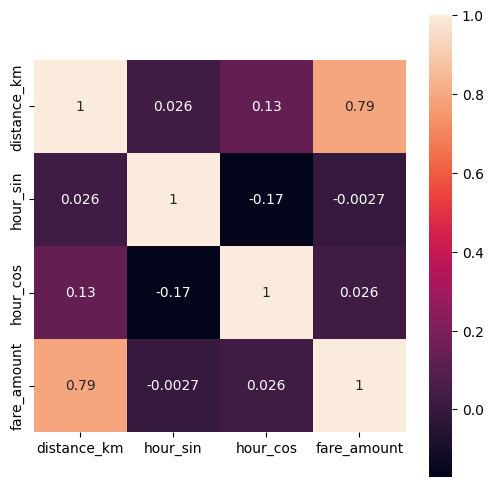

In [36]:
# Seleccionar las columnas numéricas
columns_num=['distance_km','hour_sin','hour_cos', 'fare_amount']
corr_matrix = X_train_imputed[columns_num].corr(method='pearson')
# Remove the extra figure creation and plot on the smaller figure's axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.heatmap(corr_matrix, square=True, ax=ax, annot=True)
plt.show()

A partir de la matriz de correlación podemos observar lo siguiente:

* La variable "distancia" es la única que presenta una correlación significativa con la variable target, mostrando una correlación positiva directa. Esto sugiere que, a medida que aumenta la distancia, también lo hace el valor de la variable objetivo.

* Las demás variables numéricas tienen correlaciones muy débiles o casi nulas con la tarifa, lo que indica que no hay una relación clara entre ellas y la tarifa.

* Además, se observa que las variables predictoras no presentan correlaciones significativas entre sí, lo que sugiere que no hay multicolinealidad entre las variables explicativas y permite un modelo más estable.

In [39]:
cols_to_exclude = ['key', 'date_clean','pickup_datetime','date_parsed',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'weekday', 'month', 'day', 'year',
     'fare_per_km', 'hour',
    'pickup_dt_parsed',
    'tipo_dia', 'region', 'week_of_month','passenger_count','hour_cos', 'hour_sin'
]

features = [col for col in X_train_imputed if col not in cols_to_exclude]
X_train=X_train_imputed[features].copy()
X_test=X_test_imputed[features].copy()

In [40]:
y_train=X_train['fare_amount']
y_test=X_test['fare_amount']

In [41]:
X_train=X_train.drop('fare_amount', axis=1)
X_test=X_test.drop('fare_amount', axis=1)

In [42]:
# Función auxiliar de métricas (entrenamiento y prueba)
def metrics_dict(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE%': mape}

In [47]:
X_train.isna().sum()

,0
is_off_peak_hour,0
distance_km,0
passenger_5a6,0
tipo_dia_semana,0
region_Brooklyn,0
region_Manhattan,0
region_Otra,0
region_Queens,0
region_Staten Island,0
week_of_month_2,0


In [ ]:
y_train.isna().sum()

np.int64(0)

In [ ]:
y_test.isna().sum()

np.int64(0)

In [57]:
X_train

,is_off_peak_hour,distance_km,passenger_5a6,tipo_dia_semana,region_Brooklyn,region_Manhattan,region_Otra,region_Queens,region_Staten Island,week_of_month_2,week_of_month_3,week_of_month_4,week_of_month_5
183960,0,0.419050,0,1,0,1,0,0,0,1,0,0,0
15044,1,0.548903,0,0,0,1,0,0,0,0,0,1,0
11425,0,0.361499,0,1,0,1,0,0,0,0,1,0,0
138866,0,0.135844,0,1,0,1,0,0,0,0,1,0,0
74154,1,0.235917,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119890,0,0.022161,0,1,0,1,0,0,0,0,0,0,0
103703,0,0.183055,0,0,0,1,0,0,0,0,0,1,0
131943,0,0.235917,1,1,0,1,0,0,0,0,0,0,0
146879,0,0.136557,0,0,0,1,0,0,0,0,0,0,1


#Modelos

En todos los modelos se calculan las métricas tanto sobre el conjunto de entrenamiento como sobre el conjunto de prueba con el objetivo de evaluar su capacidad de generalización.

Esta comparación permite identificar si el modelo es capaz de adaptarse adecuadamente a datos nuevos o, por el contrario, si ha incurrido en sobreajuste (overfitting), es decir, si ha aprendido en exceso las particularidades del conjunto de entrenamiento sin lograr un buen desempeño en datos no vistos.

Más adelante lograremos visualizar como los modelos logrados no se encuentran sobreajustados, ya que en la mayor  parte de los casos las métricas de test logran ser algo mejores que las de train.


##OLS


== 8) MODELADO: OLS (LinearRegression) ==
OLS - Train: {'R2': 0.6320198693558605, 'RMSE': np.float64(0.05098666421449572), 'MAE': 0.03246633441879736, 'MAPE%': np.float64(5172.507623363625)}
OLS - Test : {'R2': 0.6462022140794789, 'RMSE': np.float64(0.050800448695631405), 'MAE': 0.03259556623999981, 'MAPE%': np.float64(94491.64893524446)}


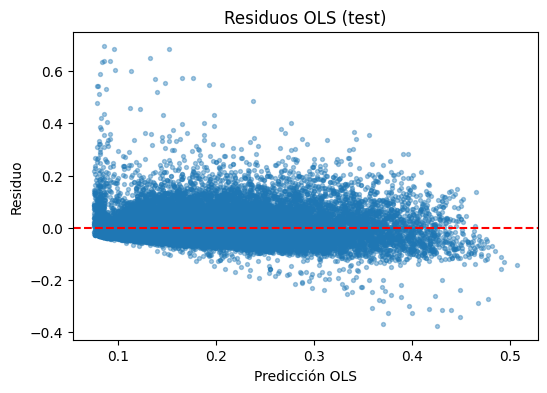


Coeficientes OLS (features in order): ['is_off_peak_hour', 'distance_km', 'passenger_5a6', 'tipo_dia_semana', 'region_Brooklyn', 'region_Manhattan', 'region_Otra', 'region_Queens', 'region_Staten Island', 'week_of_month_2', 'week_of_month_3', 'week_of_month_4', 'week_of_month_5']
[ 5.700e-03  4.281e-01  1.700e-03  3.500e-03  8.200e-03  1.300e-03
  1.490e-02  3.800e-03  8.000e-04  1.200e-03  6.000e-04  1.000e-04
 -0.000e+00]


In [60]:
# -----------------------------
# 8) Modelo OLS (LinearRegression)
# -----------------------------
print("\n== 8) MODELADO: OLS (LinearRegression) ==")
# Remove the preprocessor from the pipeline as data is already scaled
pipe_ols = Pipeline([('model', LinearRegression())])

pipe_ols.fit(X_train, y_train)

ytr_ols = pipe_ols.predict(X_train)
yte_ols = pipe_ols.predict(X_test)
print('OLS - Train:', metrics_dict(y_train, ytr_ols))
print('OLS - Test :', metrics_dict(y_test, yte_ols))

rmse_ols = np.sqrt(mean_squared_error(y_test, yte_ols))

# plot de residuos OLS (test)
plt.figure(figsize=(6,4))
plt.scatter(yte_ols, y_test - yte_ols, s=8, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción OLS')
plt.ylabel('Residuo')
plt.title('Residuos OLS (test)')
plt.show()

# Mostrar coeficientes del OLS
coef = pipe_ols.named_steps['model'].coef_

features_ols = X_train.columns
print("\nCoeficientes OLS (features in order):", features_ols.tolist())
print(np.round(coef, 4))

En el análisis de residuos del modelo OLS se observa que la mayoría de ellos se encuentran dentro del rango aproximado de -0.2 USD a 0.2 USD, lo cual indica un buen ajuste en la mayor parte de los casos. Sin embargo, en los extremos —tanto para valores muy bajos como para valores muy altos— los residuos tienden a incrementarse. Esto sugiere una mayor presencia de outliers o de observaciones que el modelo no logra explicar adecuadamente en dichos rangos.

##Gradiente Descendiente

* Batch

* Mini-batch

* Estocástico





-- GD Batch --
Train: {'R2': 0.5042285390115726, 'RMSE': np.float64(0.05918139203782624), 'MAE': 0.0410366195491416, 'MAPE%': 3755412204.686156}
Test : {'R2': 0.5122371671919344, 'RMSE': np.float64(0.05964778830401034), 'MAE': 0.041464803410740006, 'MAPE%': 32951783415.58981}

-- GD Minibatch --
Train: {'R2': 0.6255391214030722, 'RMSE': np.float64(0.05143368499086731), 'MAE': 0.03341691786969409, 'MAPE%': 2617528936.9059024}
Test : {'R2': 0.6387212586125116, 'RMSE': np.float64(0.05133471987230939), 'MAE': 0.03357982857501295, 'MAPE%': 40354206044.239914}

-- GD Stochastic --
Train: {'R2': 0.6288593177476975, 'RMSE': np.float64(0.05120515623452335), 'MAE': 0.033811052103037344, 'MAPE%': 2451969264.772939}
Test : {'R2': 0.6436032854183891, 'RMSE': np.float64(0.05098669232579072), 'MAE': 0.033940006881962366, 'MAPE%': 42879038704.02865}

--- Gráficos de Gradiente Descendente ---


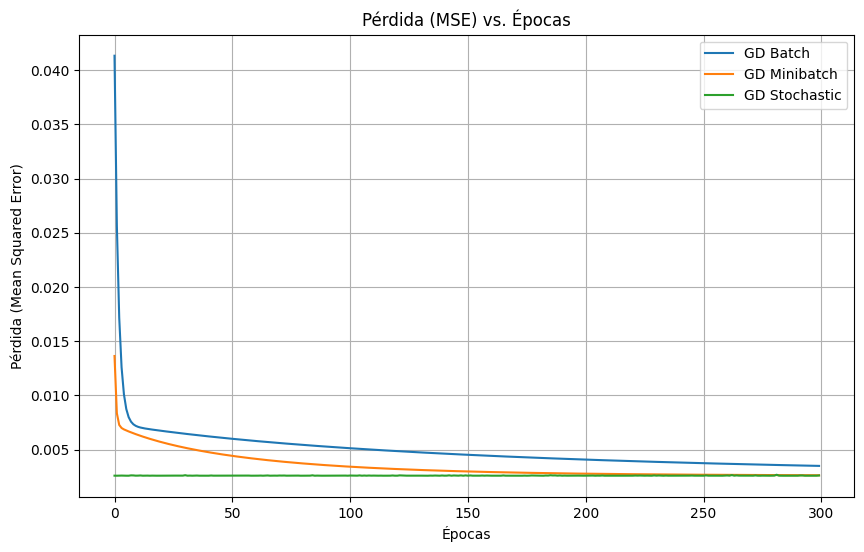

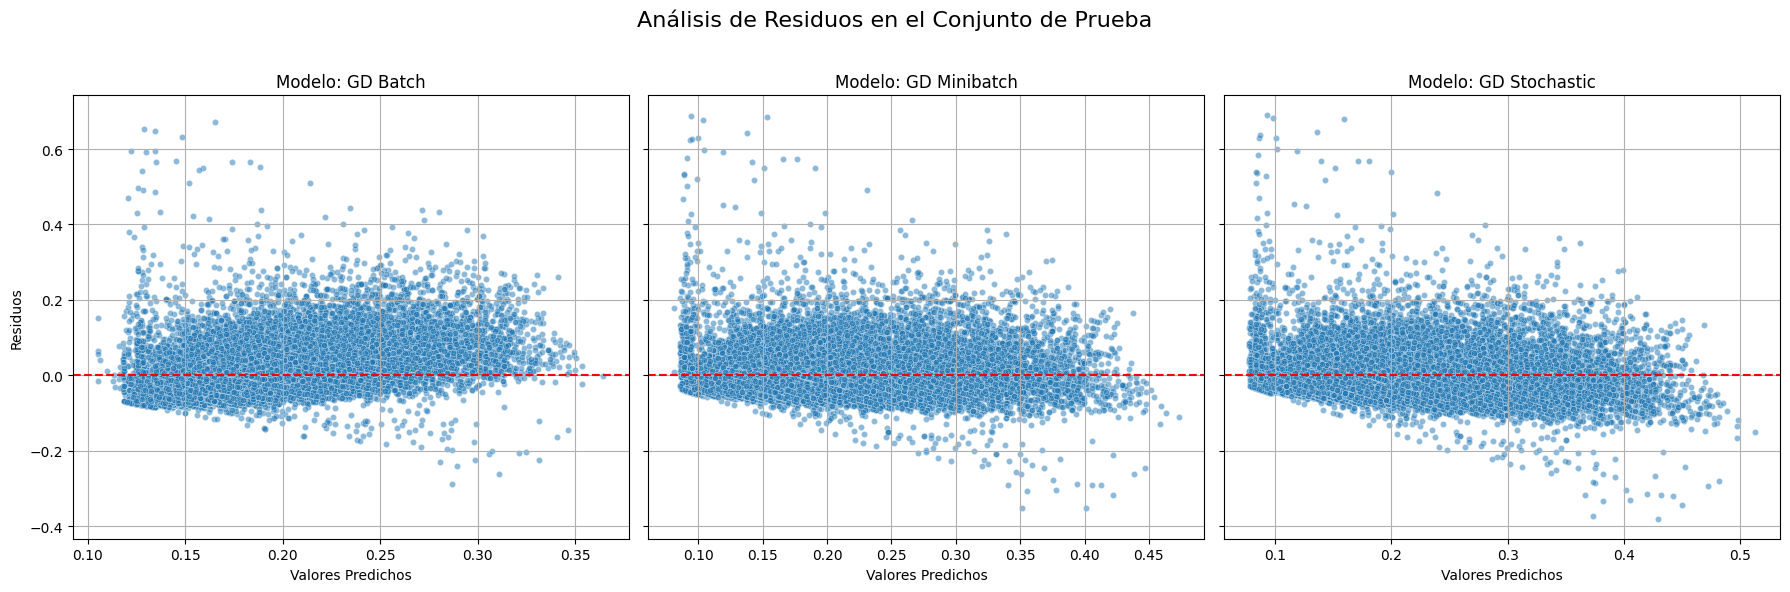

In [62]:
# ---------------------------------------------------------
# 2) Gradiente Descendiente custom (aplicado a data that was standardized outside)
# ---------------------------------------------------------
# Assuming X_train and X_test are already scaled and imputed as used for OLS


gd_batch = GDLinear(lr=0.05, epochs=300, mode='batch')
gd_batch.fit(X_train.values, y_train.values) # Using .values to work with numpy arrays expected by GDLinear
gd_minib = GDLinear(lr=0.001, epochs=300, mode='minibatch', batch_size=1000)
gd_minib.fit(X_train.values, y_train.values)
gd_stoch = GDLinear(lr=0.001, epochs=300, mode='stochastic')
gd_stoch.fit(X_train.values, y_train.values)

models_gd = {'GD Batch': gd_batch, 'GD Minibatch': gd_minib, 'GD Stochastic': gd_stoch}
for name, m in models_gd.items():
    ytr_pred = m.predict(X_train.values)
    yte_pred = m.predict(X_test.values)
    print(f"\n-- {name} --")
    print('Train:', eval_metrics(y_train, ytr_pred))
    print('Test :', eval_metrics(y_test, yte_pred))

# NUEVO: Generar los gráficos de los modelos GD
print('\n--- Gráficos de Gradiente Descendente ---')
plot_loss_history(models_gd)
plot_residuals(models_gd, X_test.values, y_test.values) # Using .values

Análisis de residuos:

* En el caso del gradiente Batch, se observa que el rango de valores predichos se encuentra aproximadamente entre 0.10 y 0.35 USD. Dentro de este intervalo, la mayoría de los residuos se concentran en el rango de -0.2 a 0.2 USD, lo que refleja un ajuste relativamente adecuado en la mayor parte de las predicciones. Sin embargo, al acercarse a los extremos —particularmente hacia el valor de 0.35 USD— los residuos tienden a adoptar valores positivos con mayor frecuencia, lo que sugiere un sesgo leve en esas zonas.

* En el caso del Gradiente Mini-Batch, el rango de valores predichos se sitúa aproximadamente entre 0.05 y 0.45 USD. A lo largo de este intervalo, el comportamiento de los residuos se muestra más estable y constante en comparación con otros métodos, lo que indica que el modelo logra mantener un desempeño más uniforme en la mayoría de los niveles de predicción.

* En el caso del Gradiente Estocástico, la mayoría de los residuos también se concentran en el rango de -0.2 a 0.2 USD, lo que refleja un ajuste aceptable en gran parte de las predicciones. No obstante, a diferencia de lo observado con el Gradiente Batch, en los valores predichos más altos los residuos tienden a volverse más negativos, lo que sugiere una ligera tendencia del modelo a subestimar las predicciones en dichos extremos.

De manera similar a lo observado en el modelo OLS,en los tres tipos de gradientes; en los valores muy bajos o muy altos se aprecia una mayor dispersión de los residuos, lo que indica que el modelo presenta más dificultades para capturar adecuadamente las observaciones en dichos extremos.

Con respecto al gráfico que muestra la relación entre la pérdida y las épocas, se observa lo siguiente:

* Gradiente Batch: presenta una convergencia considerablemente más lenta. En este caso, sería necesario incrementar el número de epochs para que logre aproximarse a los mismos valores que los otros métodos y alcanzar el óptimo esperado.

* Gradiente Mini-Batch y Estocástico: ambos exhiben una convergencia más rápida, alcanzando el óptimo en menos épocas. Sin embargo, se destaca que el gradiente estocástico llega al mínimo con mayor velocidad, lo cual coincide con lo planteado en la teoría.

Hiperparámetros en los Algoritmos de Gradiente:

En los tres enfoques de gradiente descendente (batch, minibatch y estocástico), los hiperparámetros juegan un papel crucial en el rendimiento y la eficiencia del modelo. A continuación, se detallan los efectos de cada uno de los principales hiperparámetros:

Número de épocas (iteraciones):
El número de épocas es un hiperparámetro fundamental, ya que determina cuántas veces se actualizarán los pesos del modelo durante el entrenamiento. Si el número de épocas es demasiado bajo, existe el riesgo de que el algoritmo termine el proceso sin haber alcanzado el valor óptimo, lo que podría resultar en un modelo subentrenado. Por otro lado, si el número de épocas es excesivamente alto, se incrementa el tiempo de cómputo sin garantizar necesariamente una mejora en los resultados, lo que puede ser ineficiente y costoso en términos de recursos.

Tasa de aprendizaje (learning rate, lr):
El learning rate (lr) es otro hiperparámetro crucial. Si el valor de lr es demasiado bajo, el algoritmo avanzará muy lentamente hacia el óptimo, lo que podría llevar a que no se logren buenos resultados incluso después de un gran número de iteraciones. Por el contrario, si el valor de lr es demasiado alto, el algoritmo podría "saltar" el óptimo, debido a que los pasos de actualización son demasiado grandes. Esto puede llevar a una convergencia errática o incluso a la divergencia del modelo, donde nunca se alcanza un mínimo.

Tamaño del lote (batch size):
El batch size define el número de ejemplos de entrenamiento utilizados para calcular cada actualización de los parámetros del modelo. Aunque el tamaño del lote afecta al tiempo de cómputo, su impacto sobre la capacidad del modelo para encontrar el óptimo es más indirecto. Un batch size pequeño puede aumentar la variabilidad de las actualizaciones, lo que podría ayudar a escapar de mínimos locales, mientras que un batch size grande reduce esta variabilidad y puede llevar a una convergencia más estable. Sin embargo, en cuanto a la búsqueda del óptimo, la relación no es tan directa como con el número de épocas o la tasa de aprendizaje.

Conclusión:

El ajuste adecuado de estos hiperparámetros es esencial para encontrar un equilibrio entre precisión y eficiencia computacional. Si bien el batch size tiene un impacto menor en la capacidad del modelo para encontrar el óptimo, los valores adecuados de número de épocas y tasa de aprendizaje son fundamentales para lograr una convergencia efectiva sin incurrir en un alto costo computacional.

In [63]:
# GD Batch
y_pred_batch = gd_batch.predict(X_test.values)
metrics_batch = eval_metrics(y_test, y_pred_batch)
rmse_GD_batch = metrics_batch['RMSE']

# GD Minibatch
y_pred_minib = gd_minib.predict(X_test.values)
metrics_minib = eval_metrics(y_test, y_pred_minib)
rmse_GD_minibatch = metrics_minib['RMSE']

# GD Stochastic
y_pred_stoch = gd_stoch.predict(X_test.values)
metrics_stoch = eval_metrics(y_test, y_pred_stoch)
rmse_GD_stochastic = metrics_stoch['RMSE']


##Regularización

###Ridge

Mejor valor de alpha encontrado: 0.33529241492495565
Métricas Ridge
Train: {'R2': 0.6320198638370773, 'RMSE': np.float64(0.05098666459683204), 'MAE': 0.032466757194341285, 'MAPE%': 2321214602.477732}
Test : {'R2': 0.6462011887384789, 'RMSE': np.float64(0.05080052230794216), 'MAE': 0.03259600064238599, 'MAPE%': 42544821277.93451}


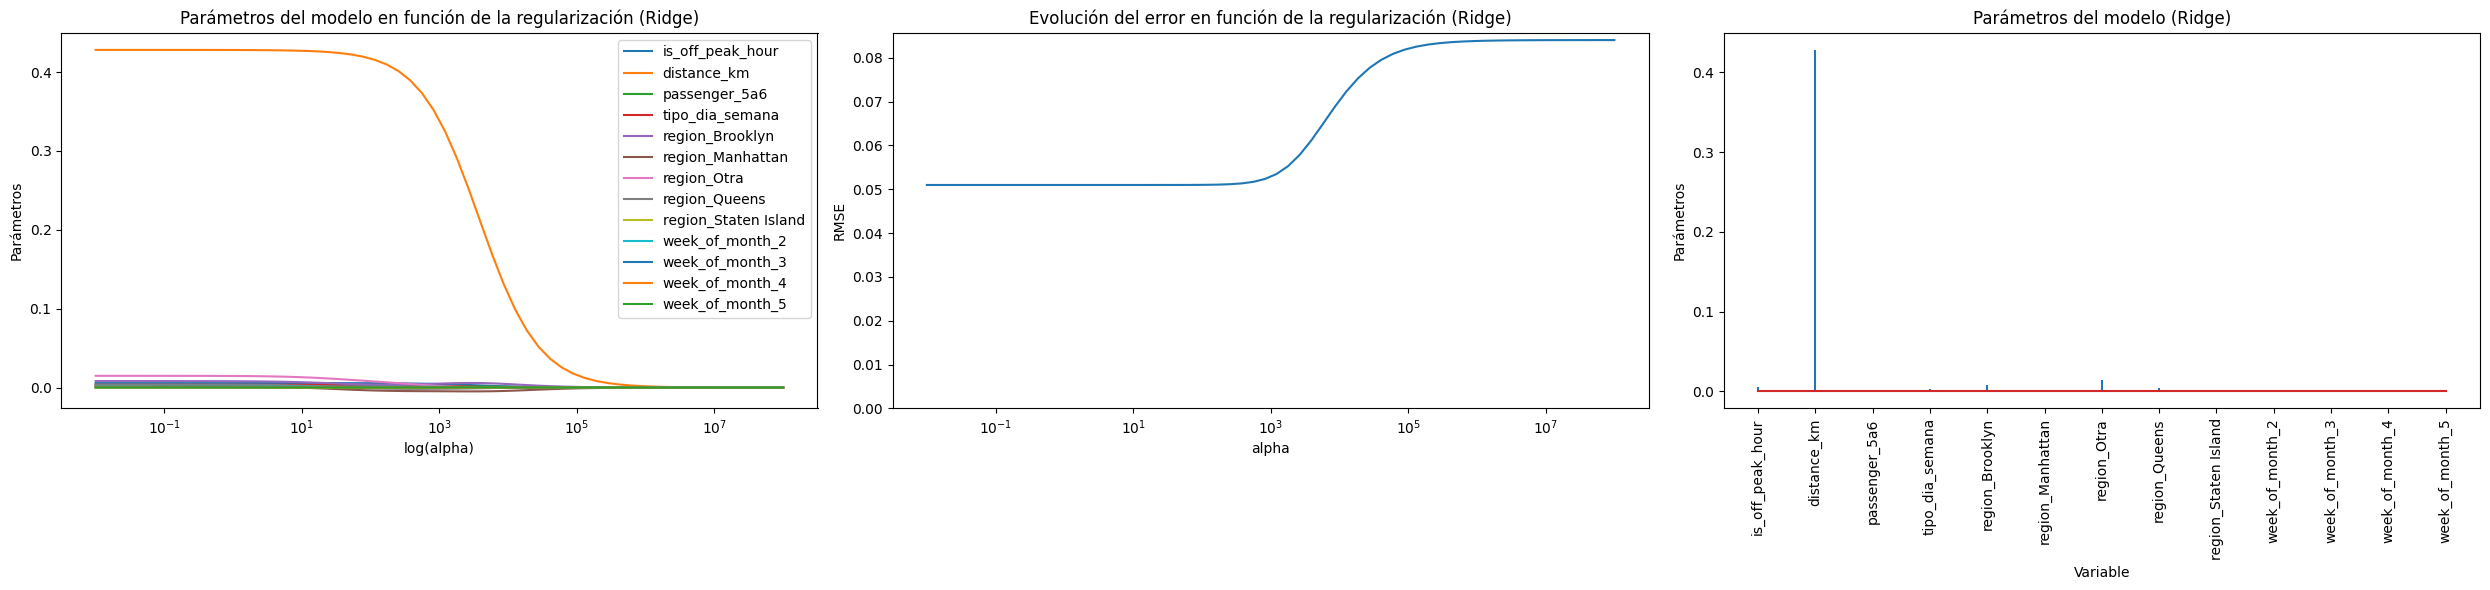

In [64]:
# Creación y entrenamiento del modelo. Scikit-Learn usa Cross Validation para encontrar el valor óptimo de alpha
# (lambda en los desarrollos de teoría). Puede ser problemático con series de tiempo.

from sklearn.pipeline import make_pipeline


# Preprocesado y modelado
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Crear y entrenar el modelo Ridge con Cross-Validation
modelo = make_pipeline(
    RidgeCV(
        alphas=np.logspace(-2, 8, 60),
        fit_intercept=True,
        store_cv_values=True
    )
)

_ = modelo.fit(X_train, y_train)

# Coeficientes en función de alpha
mod = modelo.steps[0][1] # Corrected: Access the RidgeCV model at index 0
alphas = mod.alphas
coefs = []
for alpha in alphas:
    modelo_aux = make_pipeline(Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[0][1].coef_.flatten())

# Evolución del error de validación cruzada en función de alpha
mse_cv = mod.cv_values_.mean(axis=0)
rmse_cv = np.sqrt(mse_cv)
min_rmse = np.min(rmse_cv)
optimo = mod.alphas[np.argmin(rmse_cv)]

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

# Coeficientes del modelo final
df_coeficientes = pd.DataFrame({'predictor': X_train.columns, 'coef': mod.coef_.flatten()})

# Predicciones test
yte_pred = modelo.predict(X_test)
# Predicciones de train
ytr_pred = modelo.predict(X_train)

# Error de test del modelo
#rmse_ridge = mean_squared_error(y_test, yte_pred, squared=False)
rmse_ridge = np.sqrt(mean_squared_error(y_test, yte_pred))
r2_ridge = metrics.r2_score(y_test, yte_pred)

print('Métricas Ridge')
print('Train:', eval_metrics(y_train, ytr_pred))
print('Test :', eval_metrics(y_test, yte_pred))
# Gráficos combinados
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Gráfico 1: Parámetros del modelo en función de la regularización (Ridge)
axes[0].plot(alphas, coefs, label=X_train.columns)
axes[0].set_xscale('log')
axes[0].set_xlabel('log(alpha)')
axes[0].set_ylabel('Parámetros')
axes[0].set_title('Parámetros del modelo en función de la regularización (Ridge)')
axes[0].legend(loc='best')
axes[0].set_axisbelow(True)

# Gráfico 2: Evolución del error en función de la regularización
axes[1].plot(mod.alphas, rmse_cv)
axes[1].set_xscale('log')
axes[1].set_ylim([0, None])
axes[1].set_title('Evolución del error en función de la regularización (Ridge)')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('RMSE')
axes[1].set_axisbelow(True)

# Gráfico 3: Parámetros del modelo (Ridge)
axes[2].stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
axes[2].set_xlabel('Variable')
axes[2].set_ylabel('Parámetros')
axes[2].set_title('Parámetros del modelo (Ridge)')
axes[2].tick_params(axis='x', rotation=90)
axes[2].set_axisbelow(True)

plt.tight_layout()
plt.show()

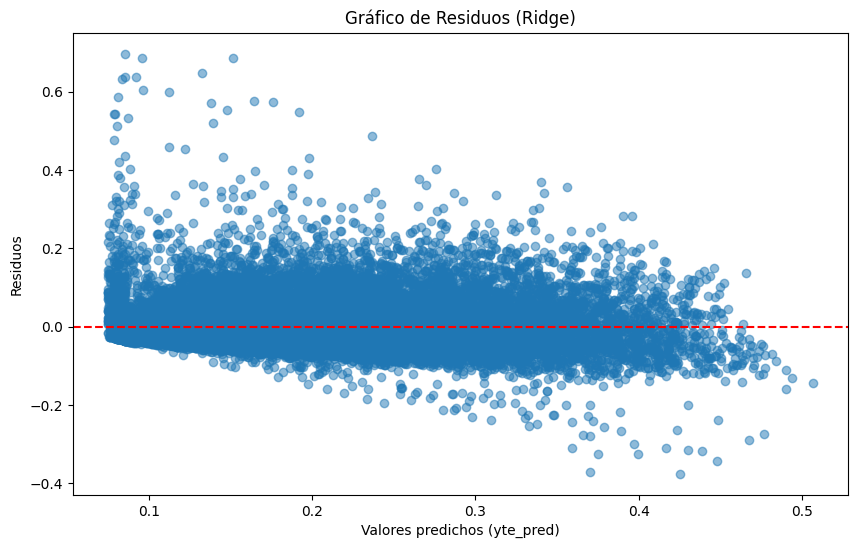

In [65]:
residuals_ridge = y_test - yte_pred

# Gráficos de Residuos
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(yte_pred, residuals_ridge, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_title('Gráfico de Residuos (Ridge)')
ax.set_xlabel('Valores predichos (yte_pred)')
ax.set_ylabel('Residuos');

En el caso del método de regularización aplicado a Ridge, los residuos se encuentran mayormente en un rango aproximado de -0.2 a 0.25 USD, mostrando un comportamiento relativamente constante a lo largo del espectro de valores predichos. Sin embargo, al igual que en el modelo OLS y en los distintos métodos de gradiente, en los valores muy bajos o muy altos se observa una mayor dispersión de los residuos. Esto sugiere la presencia de outliers o bien la dificultad del modelo para generar predicciones más cercanas a los valores reales.

###Lasso

Mejor valor de alpha encontrado: 0.001
Métricas Lasso
Train: {'R2': 0.62475708836294, 'RMSE': np.float64(0.05148736464694288), 'MAE': 0.033114197544194396, 'MAPE%': 2606123870.7163544}
Test : {'R2': 0.637783254777148, 'RMSE': np.float64(0.051401317964349824), 'MAE': 0.03329026962994039, 'MAPE%': 40455827406.393814}


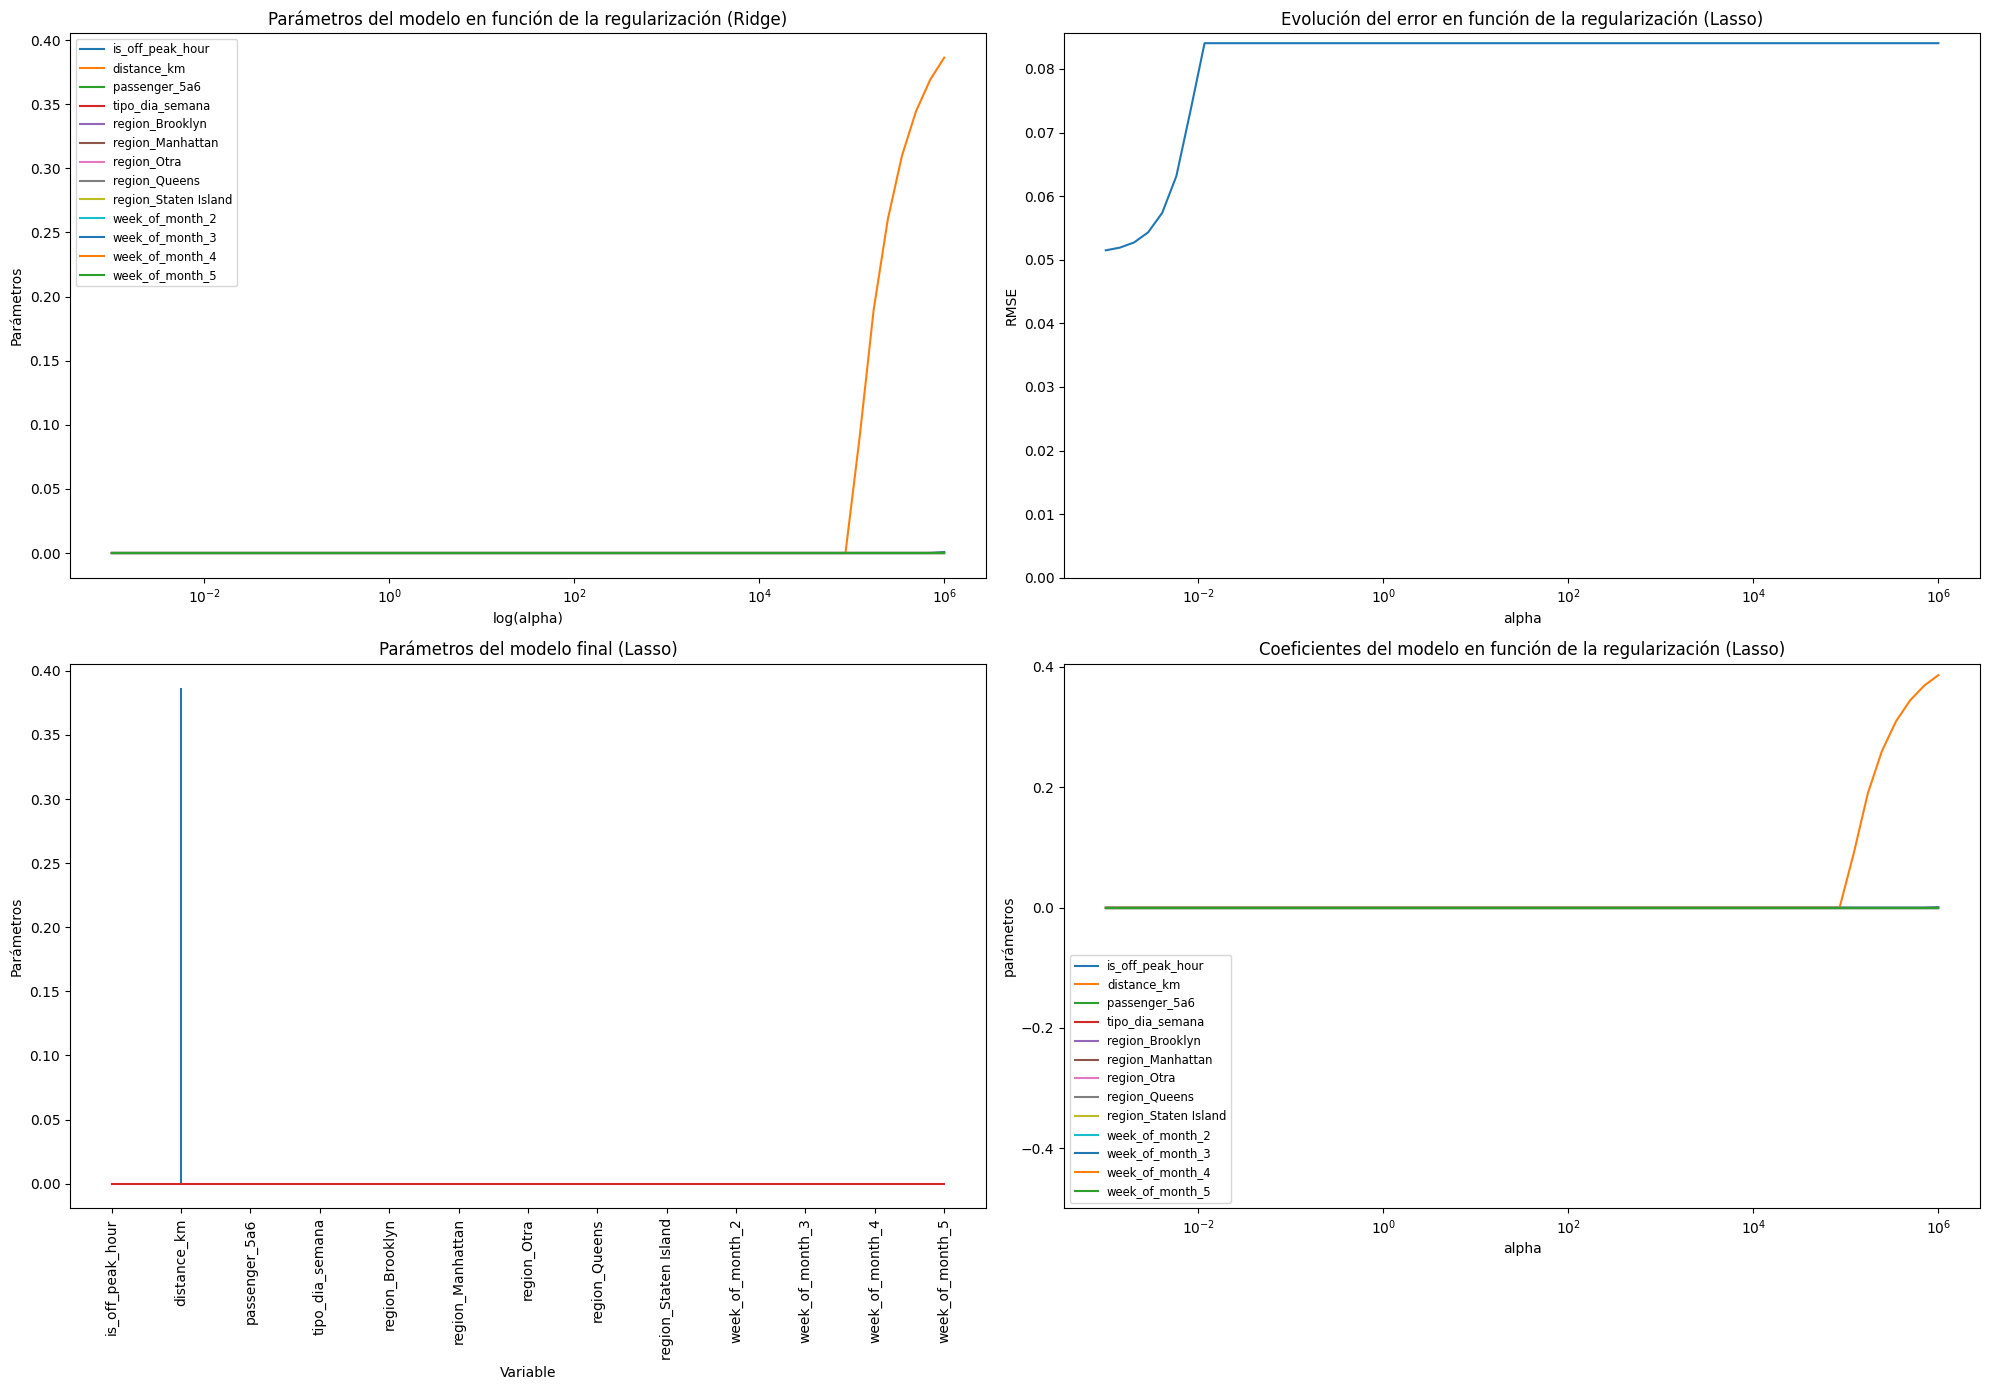

In [66]:
# Crear y entrenar el modelo Lasso con Cross-Validation
modelo = make_pipeline(
    LassoCV(
        alphas=np.logspace(-3, 6, 60),
        cv=10
    )
)
_ = modelo.fit(X_train, y_train)

# Coeficientes en función de alpha
mod = modelo.steps[0][1]
alphas = mod.alphas
coefs = []
for alpha in alphas:
    modelo_aux = make_pipeline(Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[0][1].coef_.flatten())

# Número de features incluidas (parámetros !=0) en función de alpha
alphas = mod.alphas_
n_predictores = []

for alpha in alphas:
    modelo_aux = make_pipeline( Lasso(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.steps[0][1].coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)


# Evolución del error de validación cruzada en función de alpha
mse_cv =  mod.mse_path_.mean(axis=1)
rmse_cv = np.sqrt(mse_cv)
min_rmse = np.min(rmse_cv)
optimo = mod.alphas[np.argmin(rmse_cv)]

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

# Coeficientes del modelo final
df_coeficientes_lasso = pd.DataFrame({'predictor': X_train.columns, 'coef': mod.coef_.flatten()})
df_coeficientes_lasso[df_coeficientes_lasso.coef != 0]

# Predicciones test
yte_pred = modelo.predict(X_test)
# Predicciones de train
ytr_pred = modelo.predict(X_train)

# Error de test del modelo
#rmse_ridge = mean_squared_error(y_test, yte_pred, squared=False)
rmse_lasso = np.sqrt(mean_squared_error(y_test, yte_pred))
r2_lasso = metrics.r2_score(y_test, yte_pred)

print('Métricas Lasso')
print('Train:', eval_metrics(y_train, ytr_pred))
print('Test :', eval_metrics(y_test, yte_pred))

# Gráficos combinados
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Gráfico 1: Parámetros del modelo en función de la regularización (Lasso)
axes[0, 0].plot(alphas, coefs, label=X_train.columns)
axes[0, 0].set_xscale('log')
axes[0, 0].set_xlabel('log(alpha)')
axes[0, 0].set_ylabel('Parámetros')
axes[0, 0].set_title('Parámetros del modelo en función de la regularización (Ridge)')
axes[0, 0].legend(loc='best', fontsize='small')
axes[0, 0].set_axisbelow(True)

# Gráfico 2: Evolución del error en función de la regularización (Lasso)
axes[0, 1].plot(mod.alphas_, rmse_cv)
axes[0, 1].set_xscale('log')
axes[0, 1].set_ylim([0, None])
axes[0, 1].set_title('Evolución del error en función de la regularización (Lasso)')
axes[0, 1].set_xlabel('alpha')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_axisbelow(True)

# Gráfico 3: Parámetros del modelo final (Lasso)
axes[1, 0].stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
axes[1, 0].set_xlabel('Variable')
axes[1, 0].set_ylabel('Parámetros')
axes[1, 0].set_title('Parámetros del modelo final (Lasso)')
axes[1, 0].tick_params(axis='x', rotation=90)
axes[1, 0].set_axisbelow(True)

# Gráfico 4: Coeficientes del modelo en función de la regularización (Lasso)
axes[1, 1].plot(alphas, coefs, label=X_train.columns)
axes[1, 1].set_xscale('log')
axes[1, 1].set_ylim([-0.5, None])
axes[1, 1].set_xlabel('alpha')
axes[1, 1].set_ylabel('parámetros')
axes[1, 1].legend(loc='best', fontsize='small')
axes[1, 1].set_title('Coeficientes del modelo en función de la regularización (Lasso)')
axes[1, 1].set_axisbelow(True)


plt.tight_layout()
plt.show()


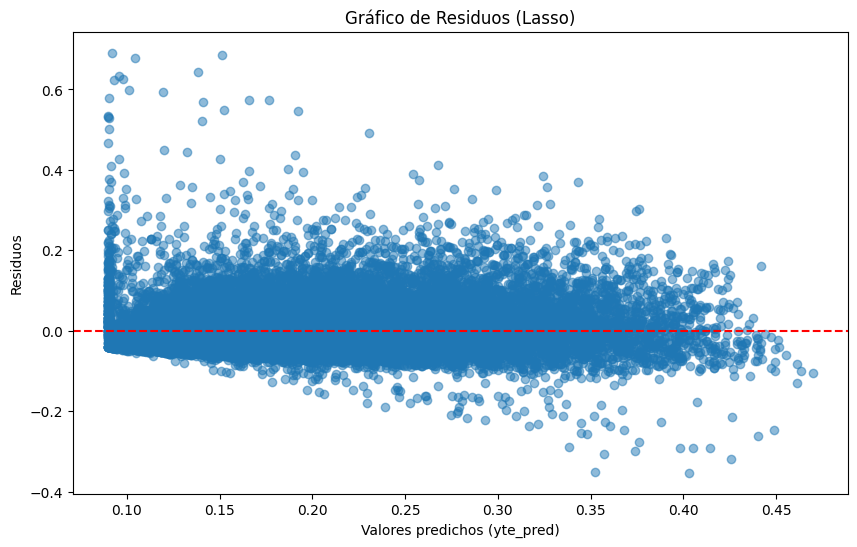

In [67]:
residuals_lasso = y_test - yte_pred

# Gráficos de Residuos
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(yte_pred, residuals_lasso, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_title('Gráfico de Residuos (Lasso)')
ax.set_xlabel('Valores predichos (yte_pred)')
ax.set_ylabel('Residuos');

En el caso del método de regularización aplicado a Lasso, los residuos se encuentran mayormente en un rango aproximado de -0.2 a 0.2 USD, mostrando un comportamiento relativamente constante a lo largo del espectro de valores predichos. Y en los valores muy bajos o muy altos se observa una mayor dispersión de los residuos. Esto sugiere la presencia de outliers o bien la dificultad del modelo para generar predicciones más cercanas a los valores reales.

###ElasticNet

Mejor valor de alpha encontrado: 0.01
Mejor valor de l1_ratio encontrado: 0.0
Métricas ElasticNet
Train: {'R2': 0.5784116394076269, 'RMSE': np.float64(0.05457436871977506), 'MAE': 0.03661121782728482, 'MAPE%': 3167544130.07853}
Test : {'R2': 0.5887820038776149, 'RMSE': np.float64(0.05476789498413659), 'MAE': 0.03685616590994303, 'MAPE%': 36159808660.9795}


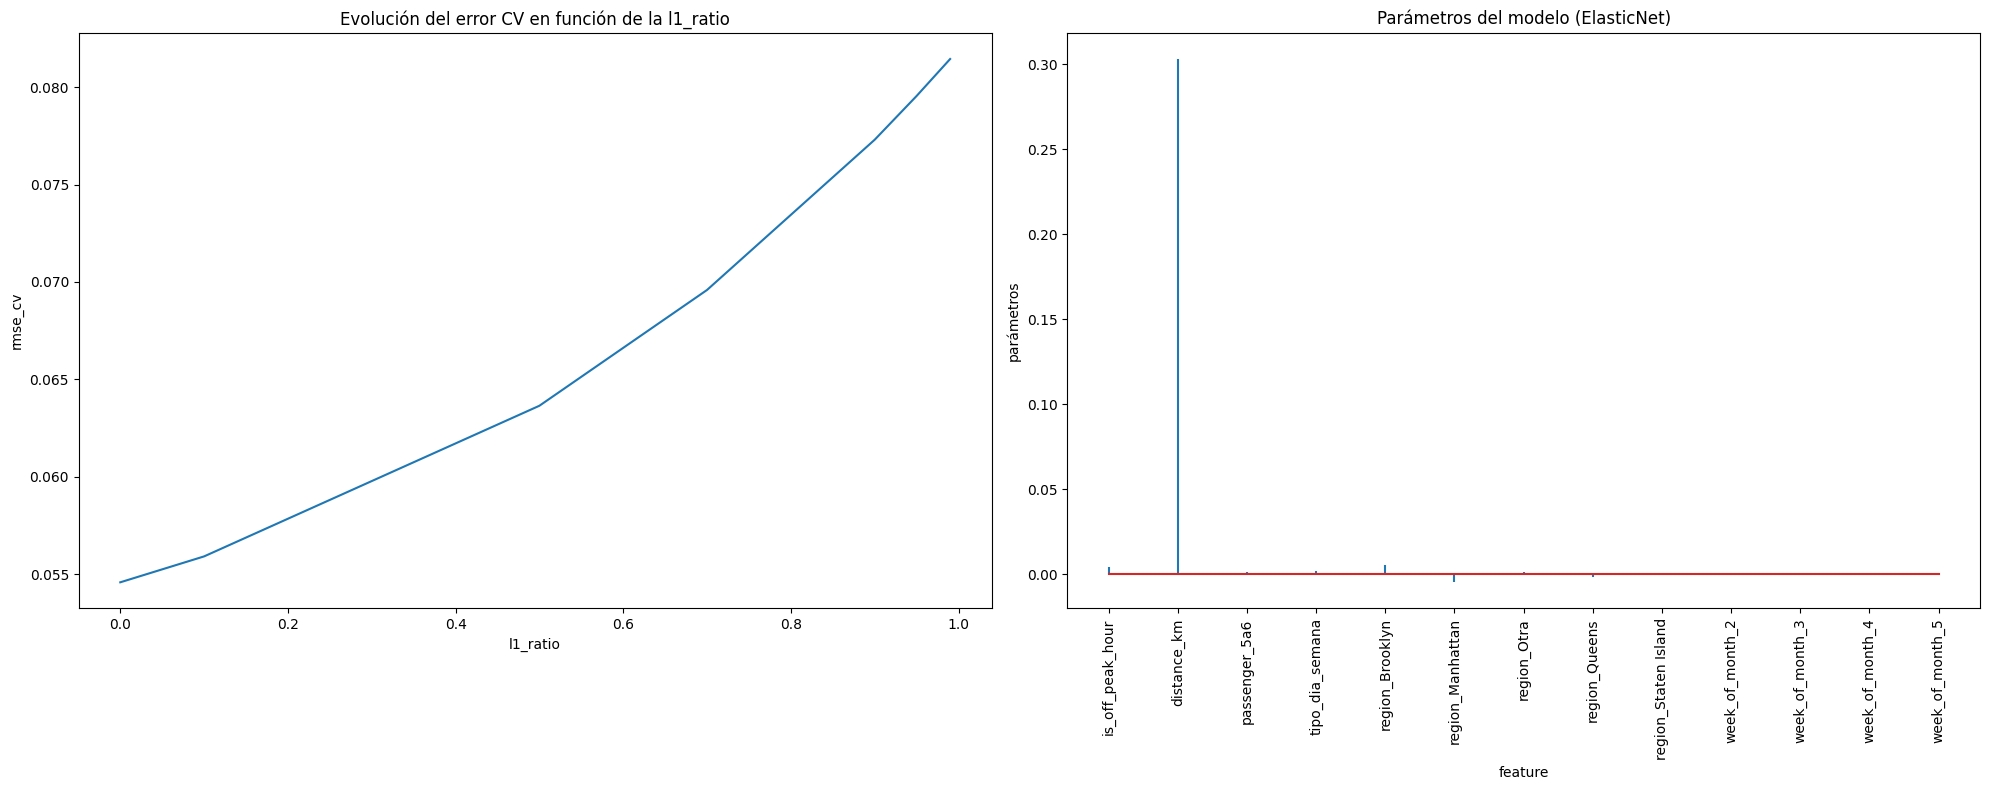

In [68]:
modelo = make_pipeline(
                        ElasticNetCV(
                              l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                              alphas          = np.logspace(-2, 8, 60),
                              cv              = 10
                           )
         )

_ = modelo.fit(X_train, y_train)

mod = modelo.steps[0][1]

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = mod.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha) se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [mod.l1_ratio, mod.alphas_],
                                    names     = ['l1_ratio', 'mod.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

# Mejor valor alpha y l1_ratio_ encontrado

print(f"Mejor valor de alpha encontrado: {mod.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {mod.l1_ratio_}")

# Parámetros del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': mod.coef_.flatten()}
                  )

# Predicciones test
ytr_pred = modelo.predict(X_train)
# Predicciones test
yte_pred = modelo.predict(X_test)

# Error de test del modelo
#rmse_elastic = mean_squared_error(y_test,yte_pred, squared = False)
rmse_elastic =np.sqrt(mean_squared_error(y_test, yte_pred))

print('Métricas ElasticNet')
print('Train:', eval_metrics(y_train, ytr_pred))
print('Test :', eval_metrics(y_test, yte_pred))


fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico 1: Evolución del error CV
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax=axes[0])
axes[0].set_title('Evolución del error CV en función de la l1_ratio')
axes[0].set_xlabel('l1_ratio')
axes[0].set_ylabel('rmse_cv')

# Gráfico 2: Parámetros del modelo
axes[1].stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
axes[1].set_title('Parámetros del modelo (ElasticNet)')
axes[1].set_xlabel('feature')
axes[1].set_ylabel('parámetros')
axes[1].tick_params(axis='x', rotation=90, labelsize=10)

plt.tight_layout()
plt.show()


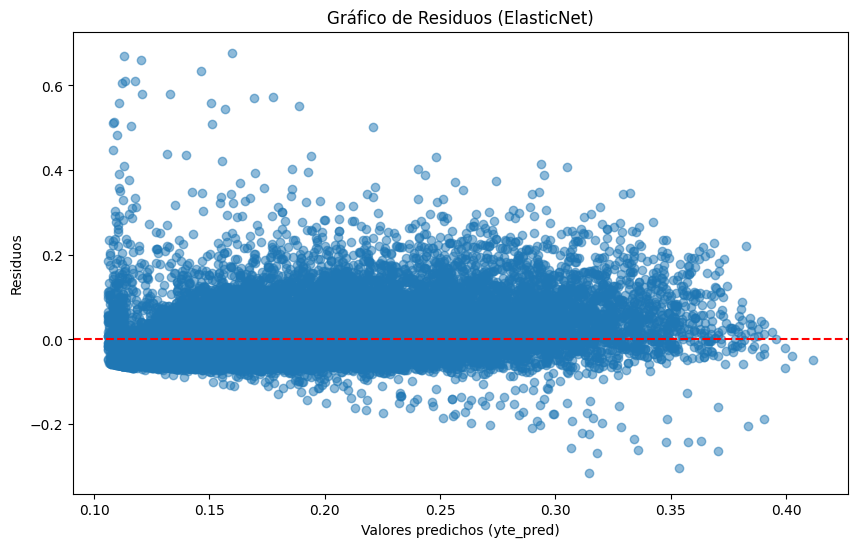

In [69]:
residuals_elastic = y_test - yte_pred

# Gráficos de Residuos
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(yte_pred, residuals_elastic, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--')
ax.set_title('Gráfico de Residuos (ElasticNet)')
ax.set_xlabel('Valores predichos (yte_pred)')
ax.set_ylabel('Residuos');

En el caso de ElasticNet, la mayoría de los residuos se concentran en un rango aproximado de -0.15 a 0.2 USD, lo que evidencia un ajuste adecuado en la mayor parte de las predicciones. No obstante, al igual que en los demás modelos, para valores muy bajos o muy altos los residuos tienden a incrementarse de manera significativa, incluso en mayor magnitud que en los otros casos. Esto refleja la dificultad del modelo para capturar con precisión las observaciones en dichos extremos.

El Ridge Regression es particularmente efectivo en situaciones donde los valores estimados tienen una alta varianza, ya que introduce una penalización sobre los coeficientes del modelo para reducir esta varianza. Al observar los resultados de ElasticNet con λ=0, podemos confirmar que este es el caso de nuestro dataset, ya que muestra una notable variabilidad en los coeficientes.

Como ya anticipábamos, la variable distancia se destaca como la más significativa en el modelo, lo cual es consistente con su impacto esperado en los precios de Uber. Dado que Ridge utiliza una regularización L2, todos los coeficientes del modelo se ajustan, sin eliminar ninguno, lo que permite mantener toda la información relevante, aunque con una penalización sobre los valores más grandes.

Análisis de los valores de α para cada método:

Ridge:
El valor de α en Ridge indica que el RSS (Residual Sum of Squares) sigue siendo relevante, pero no tan alto como para desestimar completamente su influencia. Dado que nos encontramos cerca de una regresión lineal común (donde α=0), el valor de α es lo suficientemente bajo como para permitir que el RSS juegue un papel importante, pero no tan alto como para disminuir su peso excesivamente.

Lasso:
En el caso de Lasso, el valor de α es extremadamente pequeño, lo que significa que casi ningún coeficiente se elimina. Si el valor de α fuera mayor, la regularización podría llevar a la eliminación de la mayoría de los coeficientes, lo cual no ocurre en nuestro caso debido a la pequeña penalización.

ElasticNet:
Como vimos al ejecutar los algoritmos de ElasticNet, el valor de α confirma que la regularización con Ridge tiene un peso considerablemente mayor en nuestro modelo. Esto refuerza la idea de que, en nuestro caso, la regularización L2 es la que más afecta a los coeficientes, sin llegar a eliminar ninguno de ellos.

Conclusión:

En resumen, dado el comportamiento de las tres técnicas de regularización, podemos concluir que las variables tienden a armonizarse mediante el ajuste de sus coeficientes, pero casi ninguno es eliminado. Este comportamiento es especialmente importante en el contexto de nuestro modelo, ya que mantiene la relevancia de las variables sin descartar ninguna, y asegura que no haya grandes pérdidas de información, especialmente en lo que respecta a la variable distancia, que es clave en la predicción de tarifas.

##Comparación de modelos

Para comparación de nuestros modelos elegimos la métrica RMSE ya que nos permite medir el error en las mismas unidades de nuestra variable target (USD)

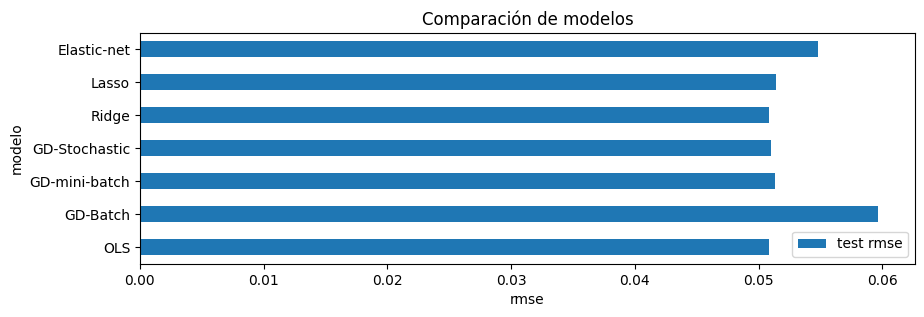

In [70]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS','GD-Batch','GD-mini-batch','GD-Stochastic', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_GD_batch, rmse_GD_minibatch , rmse_GD_stochastic , rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(10, 3))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

In [71]:
# Find the row with the minimum RMSE (the best model)
best_model = df_comparacion.loc[df_comparacion['test rmse'].idxmin()]

# Find the row with the maximum RMSE (the worst model)
worst_model = df_comparacion.loc[df_comparacion['test rmse'].idxmax()]

print("Modelo con mejor RMSE:")
print(best_model)
print("\nModelo con peor RMSE:")
print(worst_model)

Modelo con mejor RMSE:
modelo          OLS
test rmse    0.0508
Name: 0, dtype: object

Modelo con peor RMSE:
modelo       GD-Batch
test rmse    0.059648
Name: 1, dtype: object
